In [1]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
words = ["good", "bad", "worse", "so good"]
y_data = [1, 0, 0,  1]

char_set = ["<pad>"] + sorted(list(set("".join(words))))
idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


In [3]:
list(map(lambda word : [char2idx.get(char) for char in word], words))

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]

In [4]:
x_data = list(map(lambda word : [char2idx.get(char) for char in word], words))
x_data_len = list(map(lambda x : len(x), x_data))

print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


In [5]:
max_sequence = 10
x_data = tf.keras.preprocessing.sequence.pad_sequences(sequences=x_data, maxlen=max_sequence, padding="post", truncating="post", value=0)

print(x_data)

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]


In [6]:
# creating simple rnn for "many to one" classification
input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))
hidden_size = 10
n_cls = len(set(y_data))

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, trainable=False, mask_zero=True, input_length=max_sequence, embeddings_initializer=tf.keras.initializers.Constant(one_hot)))

model.add(tf.keras.layers.SimpleRNN(units=hidden_size))
model.add(tf.keras.layers.Dense(units=n_cls))

In [7]:
def loss_fn(model, x, y):
    logits = model(x)
    loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=logits, from_logits=True))
    return loss

def grad_fn(model, x, y):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x, y)
    return tape.gradient(loss, model.trainable_variables)

In [9]:
lr = 0.01
epochs = 30
batch_size = 2

train_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(len(x_data)).batch(batch_size)

train_loss_hist = []
for epoch in range(epochs):
    avg_train_loss = 0
    train_step = 0
    for x_mb, y_mb in train_dataset:
        loss = loss_fn(model, x_mb, y_mb)
        grads = grad_fn(model, x_mb, y_mb)
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        
        avg_train_loss += loss
        train_step += 1

    avg_train_loss /= train_step
    train_loss_hist.append(avg_train_loss)
         
    print("epoch : {:3}, train_loss : {:.3f}".format(epoch+1, avg_train_loss.numpy()))

epoch :   1, train_loss : 0.900
epoch :   2, train_loss : 0.688
epoch :   3, train_loss : 0.531
epoch :   4, train_loss : 0.397
epoch :   5, train_loss : 0.291
epoch :   6, train_loss : 0.211
epoch :   7, train_loss : 0.146
epoch :   8, train_loss : 0.095
epoch :   9, train_loss : 0.063
epoch :  10, train_loss : 0.038
epoch :  11, train_loss : 0.023
epoch :  12, train_loss : 0.013
epoch :  13, train_loss : 0.008
epoch :  14, train_loss : 0.005
epoch :  15, train_loss : 0.003
epoch :  16, train_loss : 0.002
epoch :  17, train_loss : 0.001
epoch :  18, train_loss : 0.001
epoch :  19, train_loss : 0.000
epoch :  20, train_loss : 0.000
epoch :  21, train_loss : 0.000
epoch :  22, train_loss : 0.000
epoch :  23, train_loss : 0.000
epoch :  24, train_loss : 0.000
epoch :  25, train_loss : 0.000
epoch :  26, train_loss : 0.000
epoch :  27, train_loss : 0.000
epoch :  28, train_loss : 0.000
epoch :  29, train_loss : 0.000
epoch :  30, train_loss : 0.000


In [71]:
pred = model.predict(x_data)
pred = np.argmax(pred, axis=-1)
is_equal = tf.cast(pred==y_data, tf.float32)

print("test_acc : {:.1%}".format(tf.reduce_mean(is_equal)))

test_acc : 100.0%


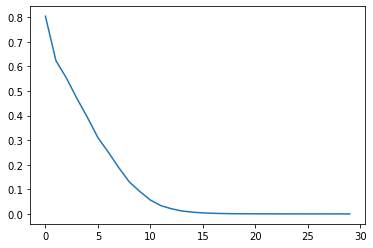

In [73]:
plt.plot(train_loss_hist)